# Model evaluation




## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [5]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))

model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
# model_file_path.mkdir(parents=True, exist_ok=True)
data_path = USER_ROOT / 'patientflow' / 'data-raw'
media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
# media_file_path.mkdir(parents=True, exist_ok=True)

## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [6]:
# indicate whether the notebook is being run locally for UCLH or with public datasets
uclh = False

In [7]:
from load import load_config_file

if uclh:
    config_path = Path(USER_ROOT / 'patientflow' / 'config-uclh.yaml')
else:
    config_path = Path(USER_ROOT / 'patientflow' / 'config.yaml')

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]


## Load data

In [10]:
import pandas as pd
from load import set_file_locations
from load import data_from_csv

if uclh:
    data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
    model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
    model_file_path.mkdir(parents=True, exist_ok=True)
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_file_locations(uclh, data_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_file_locations(uclh, data_path)

visits = data_from_csv(visits_csv_path, index_column = 'snapshot_id',
                            sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                            eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date
visits.head()



,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2030-04-09,"(12, 0)",1.0,780.0,F,45-54,Walk-in,waiting,2.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,121958,surgical
1,2030-04-09,"(15, 30)",1.0,13380.0,F,45-54,Walk-in,majors,5.0,30.0,...,0.5,141.0,6.84,7.371,5.28,train,[],False,146867,surgical
2,2030-08-03,"(12, 0)",3.0,4620.0,M,65-74,Walk-in,waiting,2.0,377.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,131932,medical
3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,NaN,sdec,4.0,400.0,...,1.2,136.0,5.41,7.371,14.10,train,[acute],True,103694,surgical
4,2030-04-24,"(12, 0)",5.0,4500.0,F,35-44,Walk-in,sdec_waiting,4.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[ambulatory],False,119879,surgical


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. This has been done chronologically, as shown by the output below. Using a chronological approach is appropriate for tasks where the model needs to be validated on unseen, future data.


In [8]:
for value in visits.training_validation_test.unique():
    subset = visits[visits.training_validation_test == value]
    counts = subset.training_validation_test.value_counts().values[0]
    min_date = subset.snapshot_date.min()
    max_date = subset.snapshot_date.max()
    print(f"Set: {value}\nNumber of rows: {counts}\nMin Date: {min_date}\nMax Date: {max_date}\n")

Set: train
Number of rows: 142335
Min Date: 2030-04-01
Max Date: 2031-08-31

Set: test
Number of rows: 44497
Min Date: 2031-11-01
Max Date: 2032-04-30

Set: valid
Number of rows: 11266
Min Date: 2031-09-01
Max Date: 2031-10-31



In [9]:
train_visits = visits[visits.training_validation_test == 'train'].drop(columns='training_validation_test')
valid_visits = visits[visits.training_validation_test == 'valid'].drop(columns='training_validation_test')
test_visits = visits[visits.training_validation_test == 'test'].drop(columns='training_validation_test')


In [17]:
# see performance of best model
for key, value in best_model_results_dict.items():
    print(f"Model: {key}; AUC: {round(value['test_set_results']['test_auc'],3)}; log loss {round(value['test_set_results']['test_logloss'],3)}")

Model: ed_admission_0600; AUC: 0.801; log loss 0.393
Model: ed_admission_0930; AUC: 0.819; log loss 0.312
Model: ed_admission_1200; AUC: 0.829; log loss 0.287
Model: ed_admission_1530; AUC: 0.829; log loss 0.321
Model: ed_admission_2200; AUC: 0.844; log loss 0.347


## Evaluation of the models predicting admission to ED

For details of how the modelling was done see notebook [4a_Predict_Probability_of_admission_from_ED.ipynb](4a_Predict_Probability_of_admission_from_ED.ipynb)

### Calibration plots

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


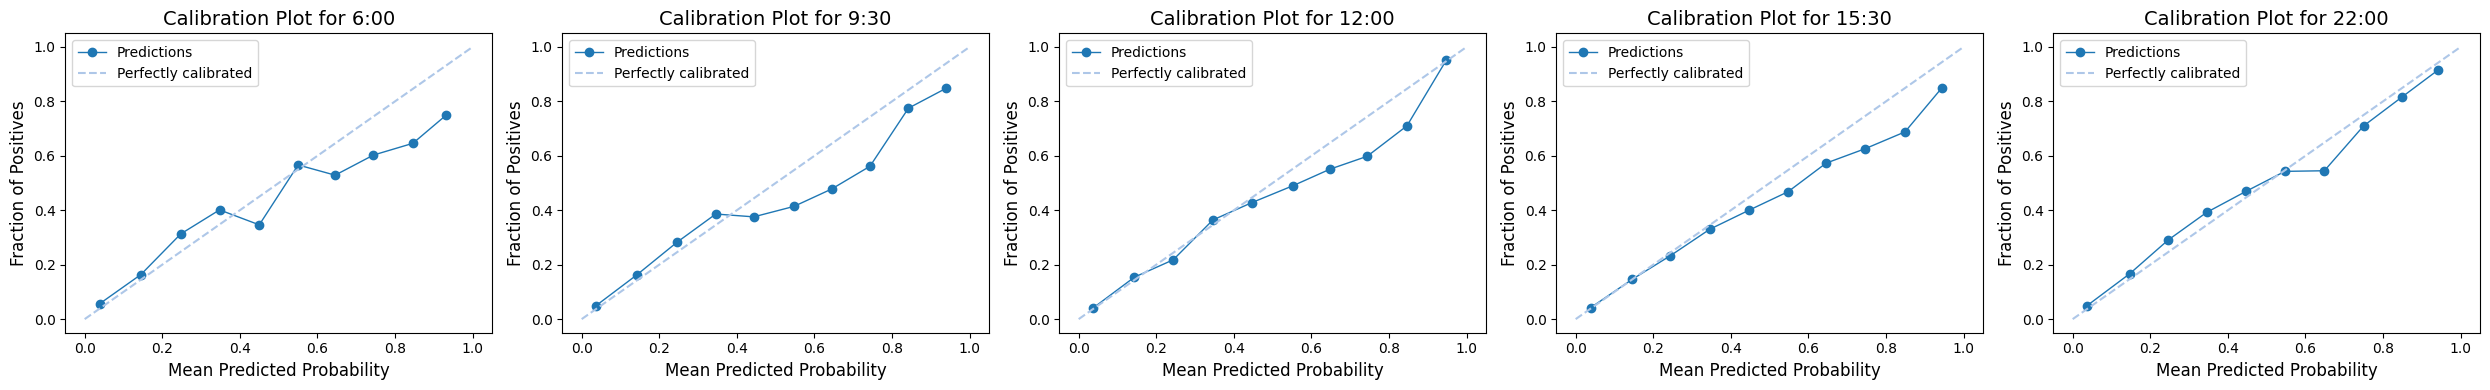

In [12]:
from prepare import prepare_for_inference


# Define the color scheme
primary_color = "#1f77b4"
secondary_color = "#aec7e8"


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

num_plots = len(prediction_times)
fig_sizes = [(num_plots * 5, 4), (num_plots * 6, 4), (10, 14), (num_plots * 8, 6)]

def plot_calibration(prediction_times, strategy = 'uniform'):
    num_plots = len(prediction_times)
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots * 5, 4))

    for i, _prediction_time in enumerate(prediction_times):
        X_test, y_test, pipeline = prepare_for_inference(model_file_path = model_file_path, model_name = 'ed_admission', prediction_time = _prediction_time, data_path = visits_csv_path, single_snapshot_per_visit = False, model_only = False)

        prob_true, prob_pred = calibration_curve(y_test, pipeline.predict_proba(X_test)[:, 1], n_bins=10, strategy=strategy)

        ax = axs[i]

        hour, minutes = _prediction_time

        ax.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Predictions', color=primary_color)
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color=secondary_color)
        ax.set_title(f'Calibration Plot for {hour}:{minutes:02}', fontsize = 14)
        ax.set_xlabel('Mean Predicted Probability', fontsize = 12)
        ax.set_ylabel('Fraction of Positives', fontsize = 12)
        ax.legend()

    plt.tight_layout()

    calib_plot_path = media_file_path / 'calibration_plot'
    calib_plot_path = calib_plot_path.with_suffix('.png')
    
    plt.savefig(calib_plot_path)
    plt.show()

    
plot_calibration(prediction_times)

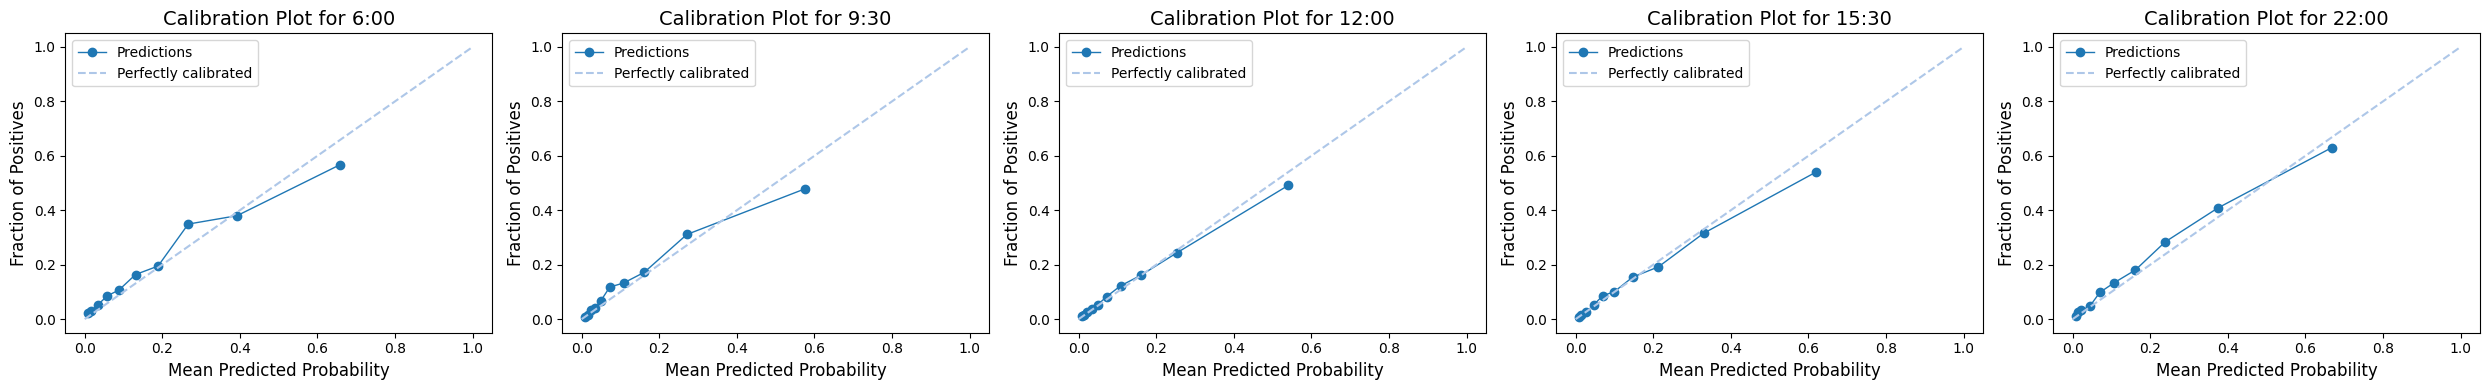

In [26]:

    
plot_calibration(prediction_times,  strategy = 'quantile')

### MADCAP plots

In [29]:
from viz.madcap_plot import plot_madcap, plot_madcap_by_group

4189


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


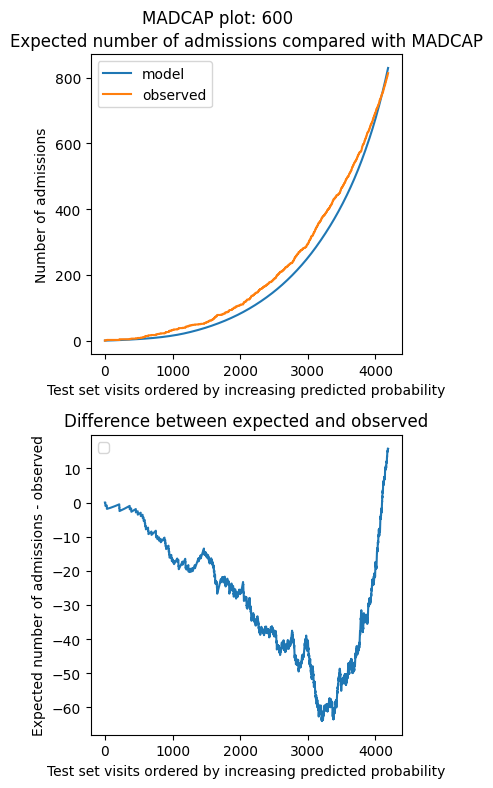

6090


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


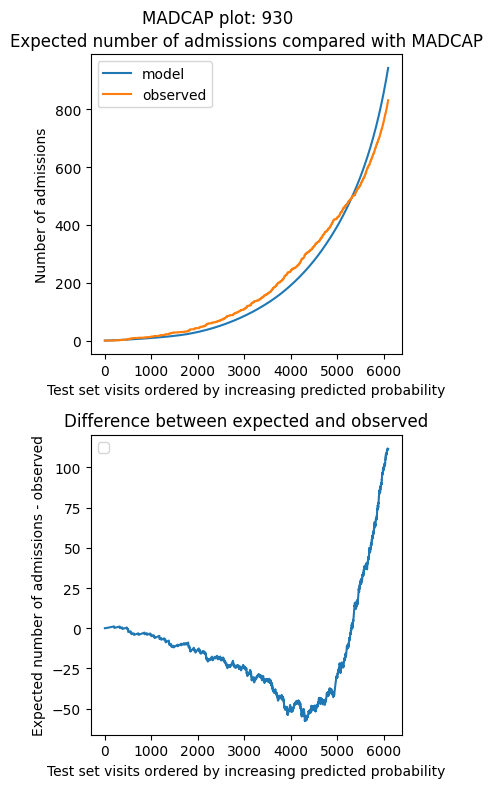

10836


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


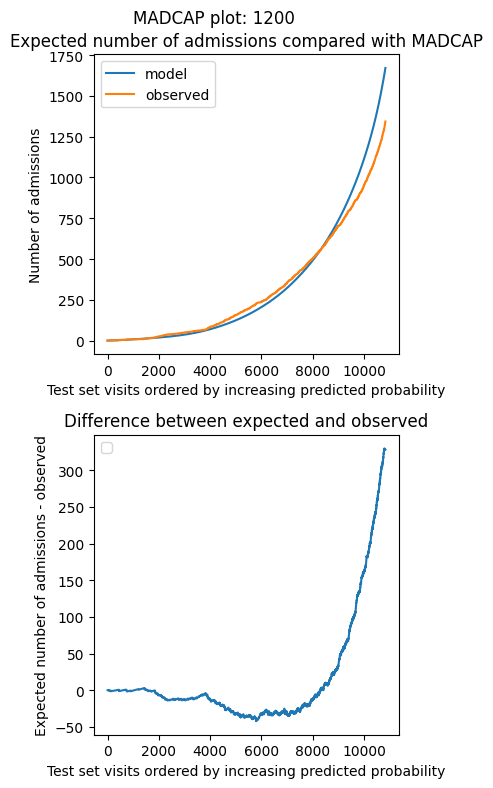

13188


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


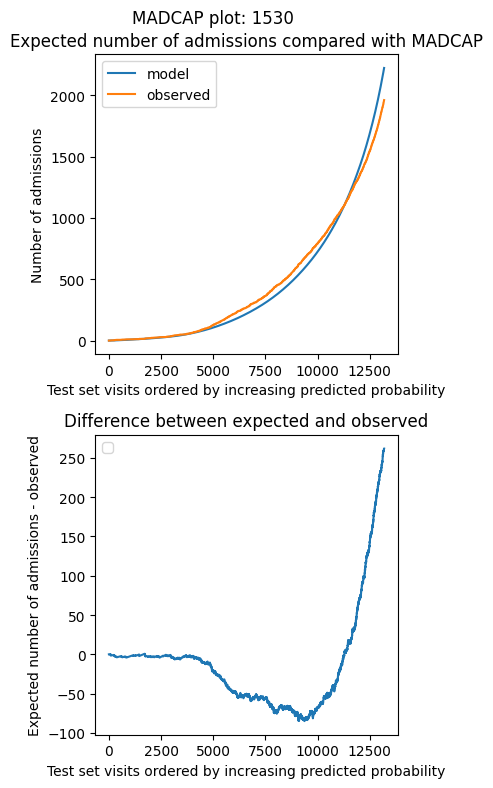

10056


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


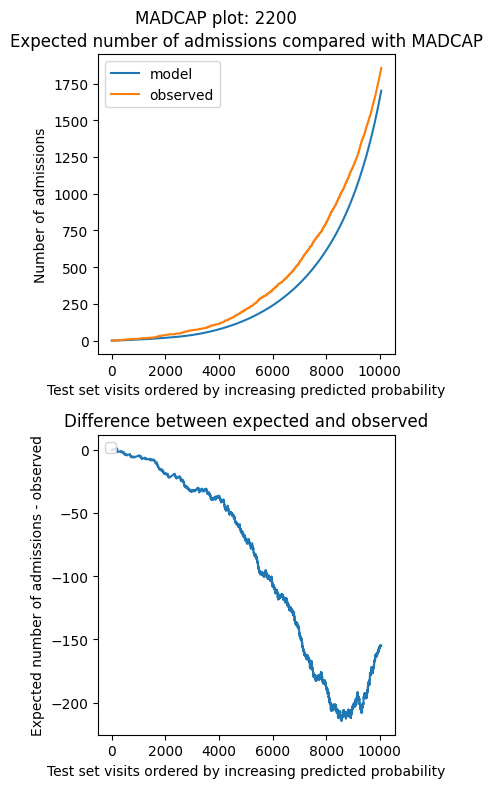

In [33]:
from prepare import get_snapshots_at_prediction_time
# Create a function to classify age groups
def classify_age_group(age_group):
    if age_group in ['0-17']:
        return 'children'
    elif age_group in ['18-24', '25-34', '35-44', '45-54', '55-64']:
        return 'adults'
    elif age_group in ['65-74', '75-102']:
        return 'over 65'
    else:
        return 'unknown' # Handle potential NaN or unexpected values

# Create a function to classify age groups
def classify_age(age_on_arrival):
    if age_on_arrival < 18:
        return 'children'
    elif age_on_arrival < 65:
        return 'adults'
        return 'over 65'
    else:
        return 'unknown' # Handle potential NaN or unexpected values
        
def generate_madcap_plots(prediction_times, grouping_var = None, grouping_var_name = None):


    for i, _prediction_time in enumerate(prediction_times):
        hour, minutes = _prediction_time
        dataset = f'{hour}{minutes:02}'

        X_test, y_test = get_snapshots_at_prediction_time(visits[visits.training_validation_test == 'test'], _prediction_time, exclude_from_training_data)
        print(len(X_test))

        predict_proba = pipeline.predict_proba(X_test)[:,1]

        if grouping_var:

            if 'age_group' in X_test.columns:

                group = X_test['age_group'].apply(classify_age_group)
            else:
                group = X_test['age_on_arrival'].apply(classify_age)
                
            plot_madcap_by_group(predict_proba, y_test , group, 
                                    dataset, grouping_var_name, media_file_path)
        
        else:
            plot_madcap(predict_proba, y_test, dataset, media_file_path)


generate_madcap_plots(prediction_times)

4189


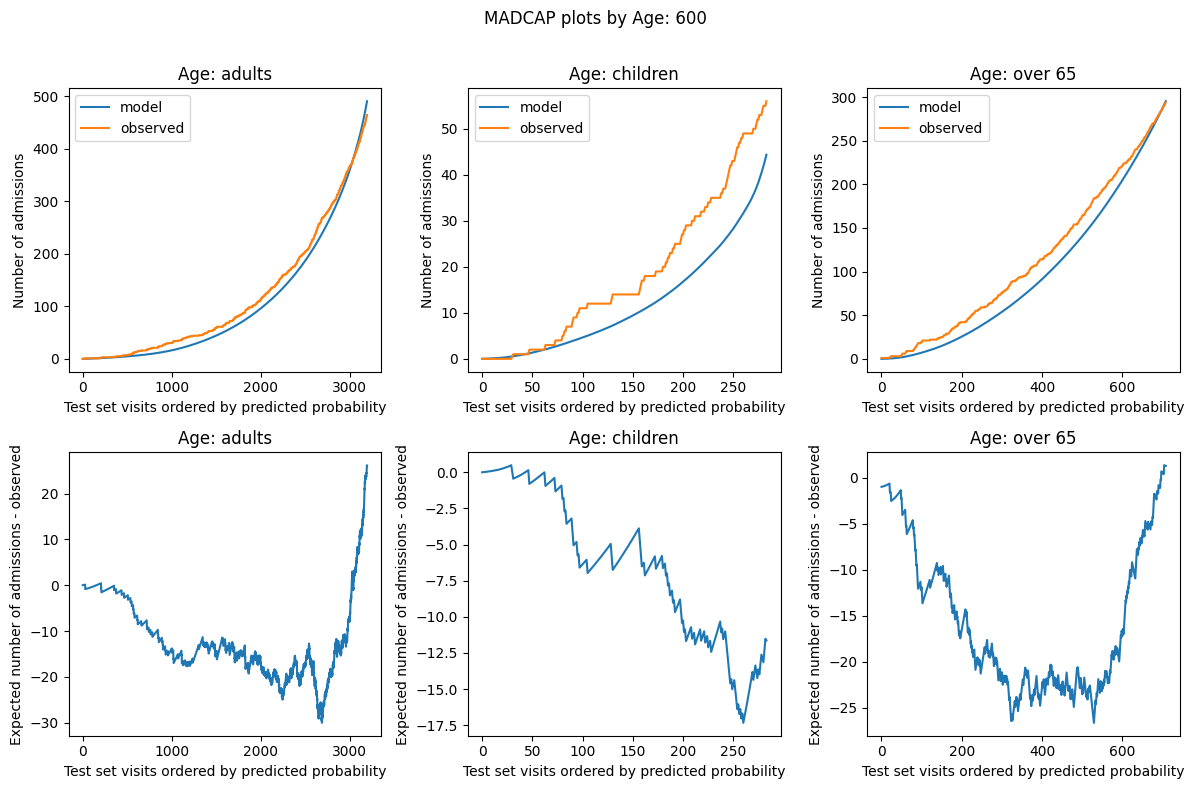

6090


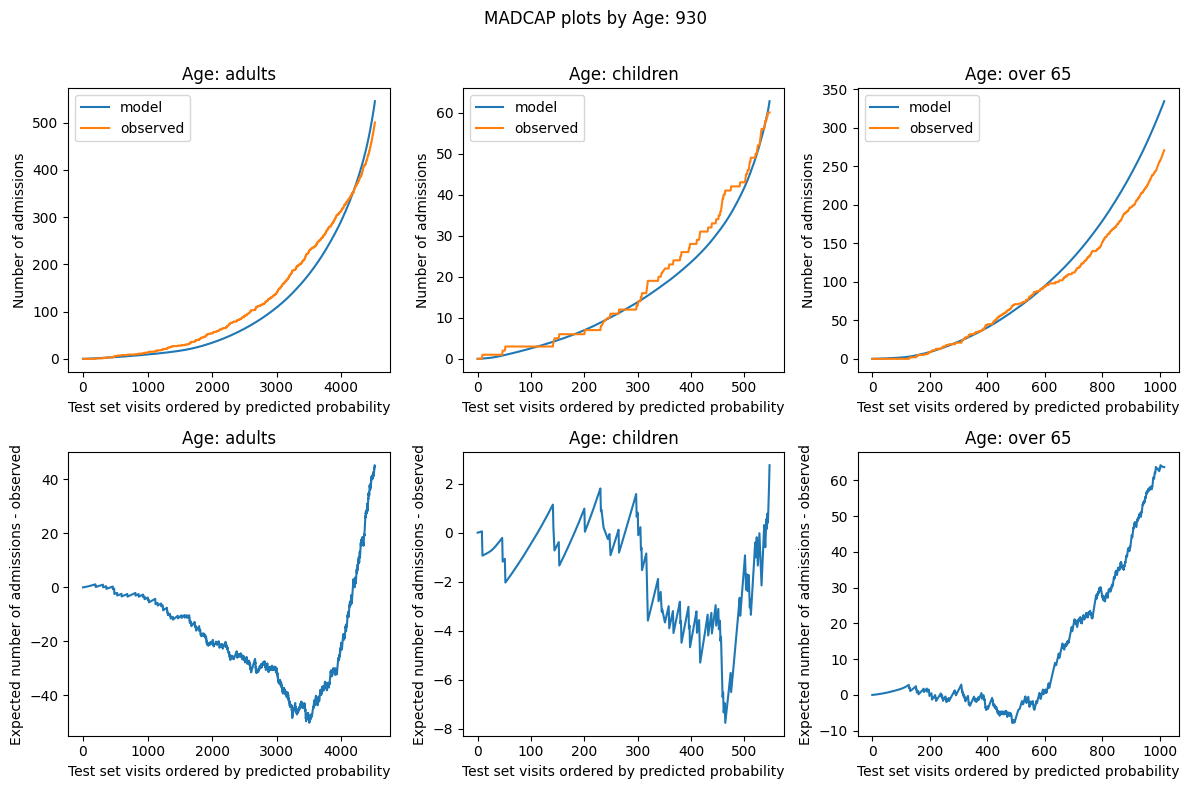

10836


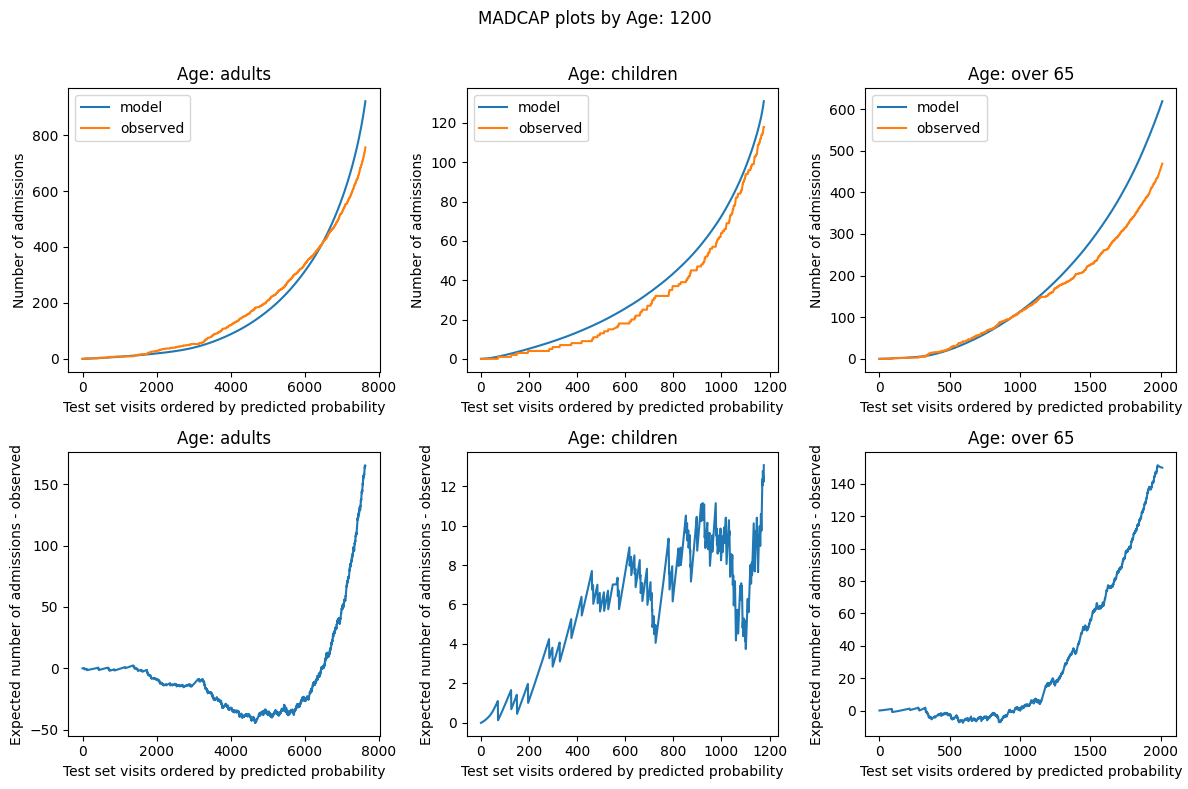

13188


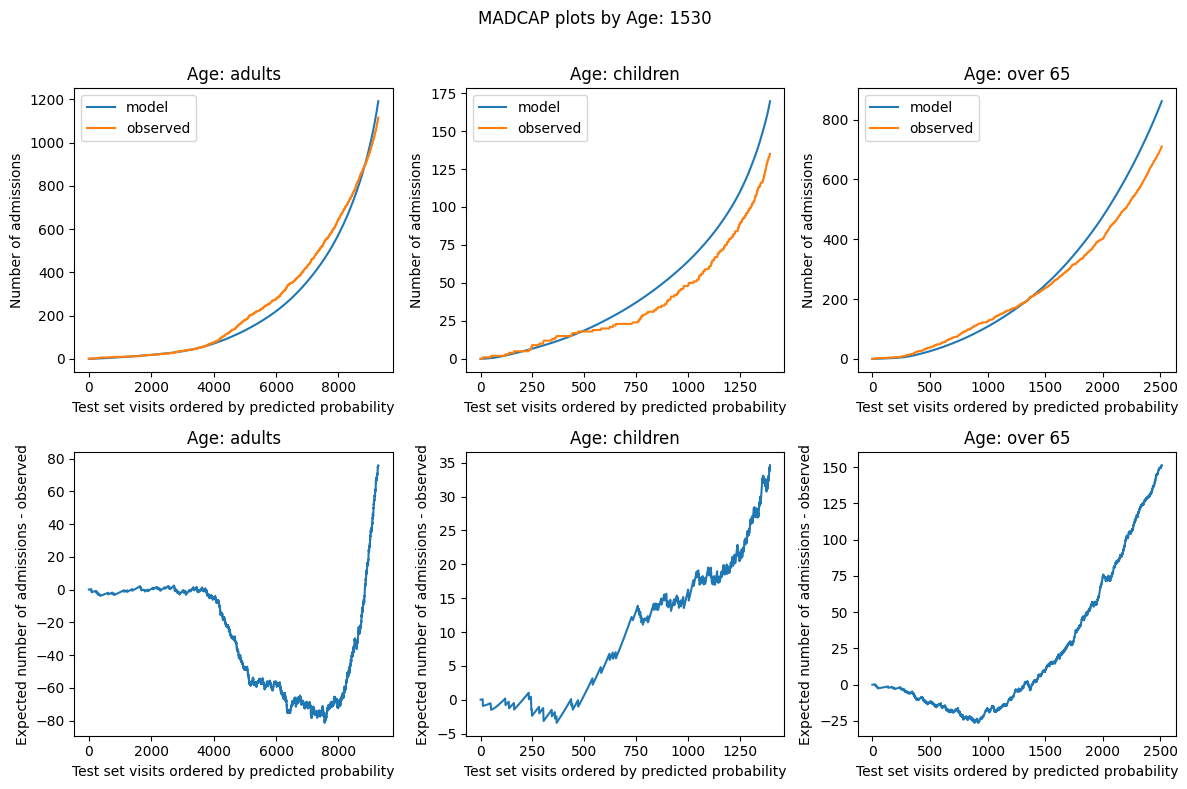

10056


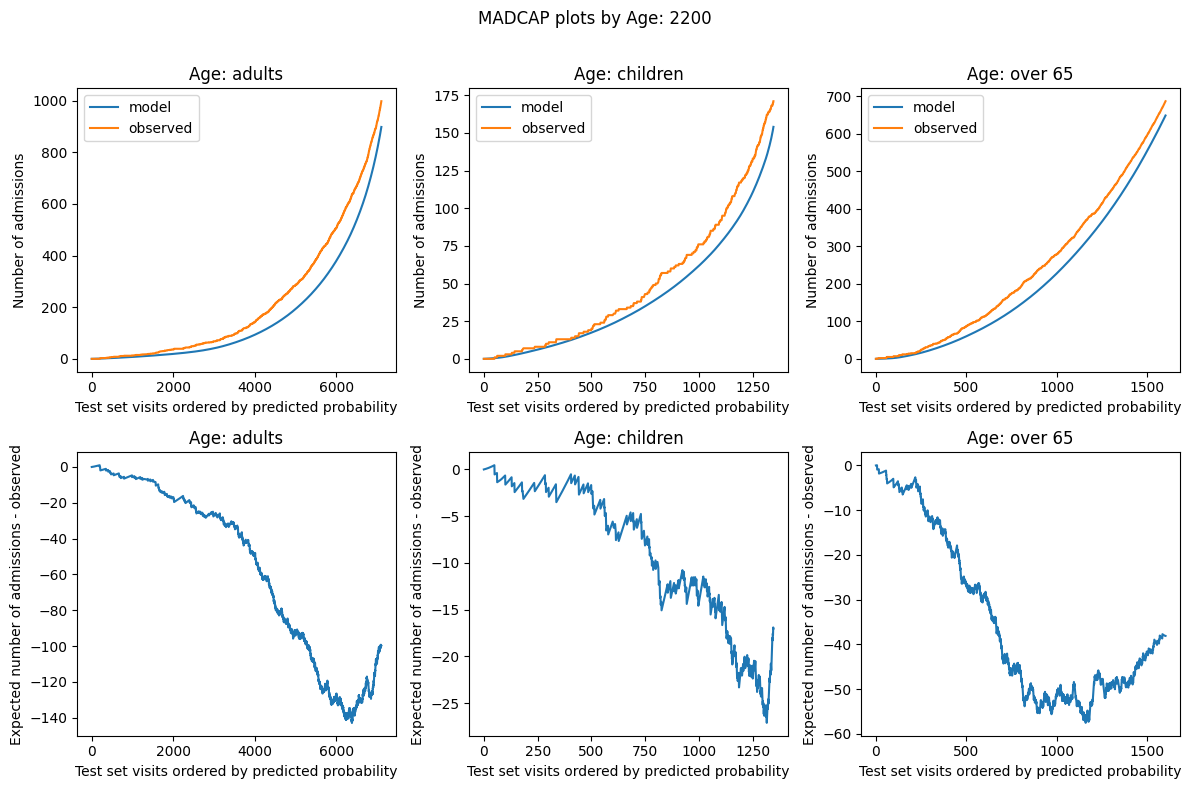

In [32]:

generate_madcap_plots(prediction_times, 'age_group', 'Age')